# Start

In [1]:
from IPython.display import display 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import akshare as ak

pd.set_option('display.max_rows', 500)

%matplotlib inline
sns.set_context(font_scale=2)

In [13]:
class StockCycle:
    def __init__(
        self, symbol="SPY", price_type="close", n_week_shift=-6, year_start=2001
    ):
        self.symbol = symbol
        # Using 'open' yields larger variance and lower gains for OCT strategy
        self.price_type = price_type
        # Holding number of weeks. Use minus
        self.n_week_shift = n_week_shift
        # Which year to start analysis
        self.year_start = year_start
        # Raw daily stock data
        self.df = None
        # Raw weekly stock data
        self.df_weekly_raw = None
        # Weekly stock data with price change over a certain number of weeks
        self.df_weekly = None

    def __download_stock(self):
        """Download stock daily price data from akshare"""

        df = ak.stock_us_daily(symbol=self.symbol, adjust="")

        df["price"] = df[self.price_type]
        df = df.drop(["open", "high", "low", "close"], axis=1)

        # Get year, month, day, etc.
        df = df.sort_values("date")
        df["year"] = df["date"].dt.year
        df["month"] = df["date"].dt.month
        df["day_of_month"] = df["date"].dt.day  # day of month
        df["week_of_year"] = df["date"].dt.isocalendar().week  # day of month
        df["day_of_week"] = df["date"].dt.dayofweek  # day of month

        self.df = df[df.year >= self.year_start]

    def _get_weekly(self):
        """Download stock daily data, aggregate to weekly"""

        self.__download_stock()
        # Get weekly price using close price of the week
        self.df["last_day_of_week"] = self.df.groupby(["year", "week_of_year"])[
            "day_of_week"
        ].transform("max")
        df_weekly_holder = self.df[
            self.df["day_of_week"] == self.df["last_day_of_week"]
        ].drop(["day_of_week"], axis=1)

        df_weekly_holder["week_of_month"] = df_weekly_holder.groupby(["year", "month"])[
            "date"
        ].rank()
        df_weekly_holder["week_of_month_reverse"] = df_weekly_holder.groupby(
            ["year", "month"]
        )["date"].rank(ascending=False)

        self.df_weekly_raw = df_weekly_holder

    def __shift_weeks(self, n_week_shift):
        """Compute price change over n_week_shift weeks"""

        df_weekly = self.df_weekly_raw.copy()
        df_weekly["date_out"] = df_weekly["date"].shift(n_week_shift)
        df_weekly["price_out"] = df_weekly["price"].shift(n_week_shift)

        # d_price at weeky m is the difference with price at n and price at m
        df_weekly["d_price"] = df_weekly["price_out"] - df_weekly["price"]
        df_weekly = df_weekly.set_index("date")
        return df_weekly

    def _get_weekly_gains(self):
        self.df_weekly = self.__shift_weeks(self.n_week_shift)

    def plot_gains_by_reverse_week(self, year_skip=9999):
        """Plot gains for each month, given holding weeks, varying by reverse week number"""

        fig = plt.figure(figsize=(12, 6))
        max_time = []
        for i in range(1, 5):
            ax = fig.add_subplot(2, 2, i)
            df_plot = self.df_weekly[
                (self.df_weekly.week_of_month_reverse == i)
                & (self.df_weekly.year != year_skip)
            ].groupby("month")["d_price"]
            df_plot.mean().plot(
                kind="bar", title=f"reverse_week {i}\n", ax=ax, yerr=df_plot.std()
            )
            max_time.append((self.n_week_shift, i, df_plot.mean().max()))
        print(max_time)

    def plot_gains_by_month_boxplot(self, week_plot_reverse=2):
        """Plot gains by month given week_plot_reverse and holding weeks"""
        self.df_weekly[
            (self.df_weekly.week_of_month_reverse == week_plot_reverse)
        ].boxplot(column="d_price", by="month")

    def plot_gain_by_year(
        self, month_plot, week_plot_reverse, plot_var="d_percent", year_skip=9999
    ):
        """Plot gains for each year, given a strategy of buying month and reverse week, and holding weeks"""
        df_weekly_week_plot = (
            self.df_weekly[
                (self.df_weekly.month == month_plot)
                & (self.df_weekly.week_of_month_reverse == week_plot_reverse)
                & (self.df_weekly.year != year_skip)  # This doesn't matter for Oct
            ]
        ).copy()
        df_weekly_week_plot["d_percent"] = (
            df_weekly_week_plot["d_price"] / df_weekly_week_plot["price"] * 100
        )
        df_weekly_week_plot[plot_var].plot(
            kind="bar",
            ylabel=plot_var,
            title=f"""{plot_var} of month {month_plot}, reverse week {week_plot_reverse}; holding for {-self.n_week_shift} weeks; mean: {df_weekly_week_plot[plot_var].mean():.2}""",
        )

    def plot_gain_by_holding_week(self, month_plot, week_plot_reverse, year_skip=9999):
        """Plot gains for all year varying by holding weeks, given a strategy of buying month and reverse week"""
        results = []
        # Loop over holding weeks and get the gains
        for n in range(-4, -13, -1):
            df_weekly = self.__shift_weeks(n)
            df_weekly_week_plot = df_weekly[
                (df_weekly.month == month_plot)
                & (df_weekly.week_of_month_reverse == week_plot_reverse)
                & (df_weekly.year != year_skip)  # This doesn't matter for Oct
            ]
            results.append(
                (
                    -n,
                    df_weekly_week_plot["d_price"].mean(),
                    df_weekly_week_plot["d_price"].quantile(0.1),
                    df_weekly_week_plot["d_price"].quantile(0.25),
                    df_weekly_week_plot["d_price"].quantile(0.5),
                )
            )

        df_result = pd.DataFrame(
            results, columns=["holding_week", "mean", "q10", "q25", "q50"]
        )
        f, a = plt.subplots()
        df_result.plot(x="holding_week", y="q10", kind="bar", color="y", ax=a)
        df_result.plot(x="holding_week", y="mean", kind="bar", ax=a)

    def plot_price_history(
        self,
        year_center="October",
        years=None,
        week_of_month_reverse=2,
        month=10,
        rows_fig=3,
        cols_fig=3,
        vline1_week=4,
        vline2_week=6,
    ):
        """Plot price series around a certain month for specific years"""

        if year_center == "October":
            month_range = range(7, 13)
        elif year_center == "March":
            month_range = range(1, 6)
        elif year_center == "June":
            month_range = range(4, 11)
        else:
            print("Wrong month")
            return

        df_month = self.df_weekly_raw[self.df_weekly_raw.month.isin(month_range)]
        df_month_selected = (
            df_month if years is None else df_month[df_month.year.isin(years)]
        )
        grouped = df_month_selected.groupby("year")
        f = plt.figure(figsize=(20, 4 * rows_fig))
        print(4 * rows_fig)
        i = 0
        for year, group in grouped:
            i += 1
            ax = f.add_subplot(rows_fig, cols_fig, i)
            group = group.set_index(
                "date"
            )  # axvline and plot use different logic for x, I need to make sure they are consistent

            group.plot(y="price", ax=ax, title=year)

            x_value = group[
                (group.week_of_month_reverse == week_of_month_reverse)
                & (group.month == month)
            ].index.values
            ax.axvline(x=x_value, alpha=0.5, color="y")
            ax.axvline(
                x=x_value - pd.Timedelta(weeks=vline1_week), alpha=0.5, color="grey"
            )
            ax.axvline(
                x=x_value + pd.Timedelta(weeks=vline2_week), alpha=0.5, color="grey"
            )

    def plot_gain_by_reverse_week_holding_week(self, month_plot, year_skip=9999):
        """Loop to see the best combination of reverse weeks and holding weeks
        Best means high mean and low q10 (risk)
        """
        results = []
        week_plot_reverse_list = range(1, 4)
        for week_plot_reverse in week_plot_reverse_list:
            for n in range(-2, -15, -2):
                df_weekly = self.__shift_weeks(n)
                df_weekly_week_plot = df_weekly[
                    (df_weekly.month == month_plot)
                    & (df_weekly.week_of_month_reverse == week_plot_reverse)
                    & (df_weekly.year != year_skip)
                ]
                results.append(
                    (
                        -n,
                        week_plot_reverse,
                        df_weekly_week_plot["d_price"].mean(),
                        df_weekly_week_plot["d_price"].quantile(0.1),
                        df_weekly_week_plot["d_price"].quantile(0.25),
                        df_weekly_week_plot["d_price"].quantile(0.5),
                    )
                )

        df_result = pd.DataFrame(
            results,
            columns=["holding_week", "reverse_week", "mean", "q10", "q25", "q50"],
        )
        f, a = plt.subplots()
        df_result.plot(
            x="holding_week",
            y=["q50", "q10", "mean"],
            kind="bar",
            ax=a,
            title=f"d_price mean and quantiles when buying from the {list(week_plot_reverse_list)}nd to last Friday",
        )
        plt.show()

# SP500 index

## Explore the stats of n week price diff

### The n to the last Friday of each month - compare the gains
**If buying in on the 2nd to the last Friday of October, one gets the most gain after 6 weeks**  
March is another month with large gain and relatively low risk

SPY misses the following years after 2001 set(); 
And some years have missing weeks: year
2024    26
Name: week_of_year, dtype: Int64 
[(-6, 1, 6.071818181818173), (-6, 2, 7.433181818181819), (-6, 3, 6.750454545454548), (-6, 4, 6.711818181818183)]


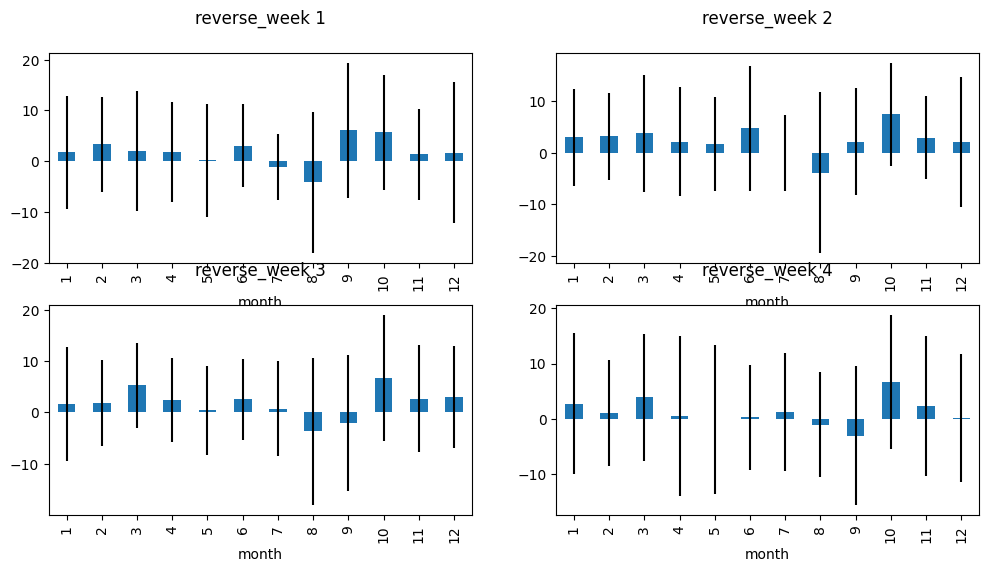

In [3]:
spy_cycle = StockCycle(symbol="SPY", n_week_shift=-6)
spy_cycle._get_weekly()
spy_cycle._get_weekly_gains()

tmp = spy_cycle.df_weekly
tmp2 = tmp.groupby("year")["week_of_year"].count()
tmp2 = tmp2[tmp2 < 52]
print(
    f"""SPY misses the following years after 2001 {set(range(2001, 2025)) - set(tmp.year.unique())}; 
And some years have missing weeks: {tmp2} """
)

year_skip = 2020  # Skip 2020 covid - The result holds for Oct, but March changes a lot
spy_cycle.plot_gains_by_reverse_week(year_skip=year_skip)

### Boxplot comparison of the purchased month, when buying on the 2nd to the last Friday
**Oct has high median and highest q10**

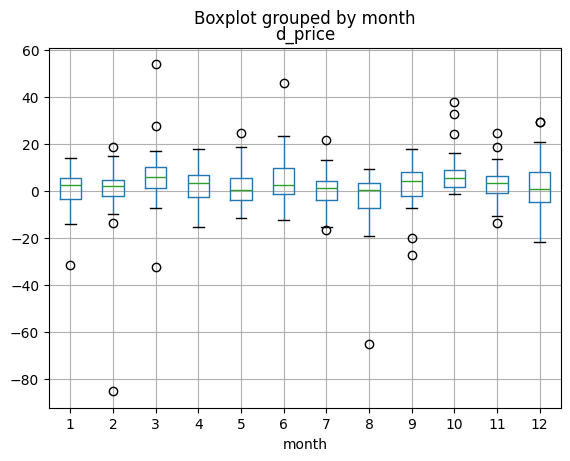

In [4]:
week_plot_reverse = 2
spy_cycle.plot_gains_by_month_boxplot(week_plot_reverse=week_plot_reverse)

### Price change of individual year when choosing the aforementioned strategy
**to buy in on the 2nd to the last Friday of October, and sell after 6 weeks**

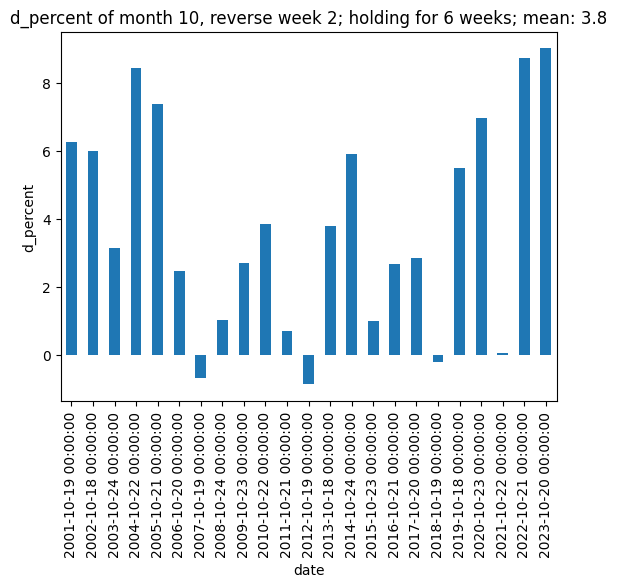

In [5]:
month_plot = 10
spy_cycle.plot_gain_by_year(month_plot=month_plot, week_plot_reverse=week_plot_reverse)

## Explore the effect of holding time

### Starting 2nd to the last Friday in Oct
**The best is 6 weeks**

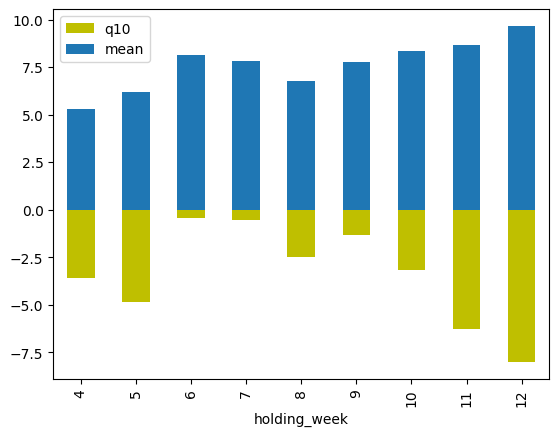

In [6]:
month_plot = 10
week_plot_reverse = 2
spy_cycle.plot_gain_by_holding_week(
    month_plot=month_plot, week_plot_reverse=week_plot_reverse
)

## Specific cases for October - what the raw price data looks like
This shows detailed timing for purchase and sale and helps determine the strategy  
See ON for the strategies

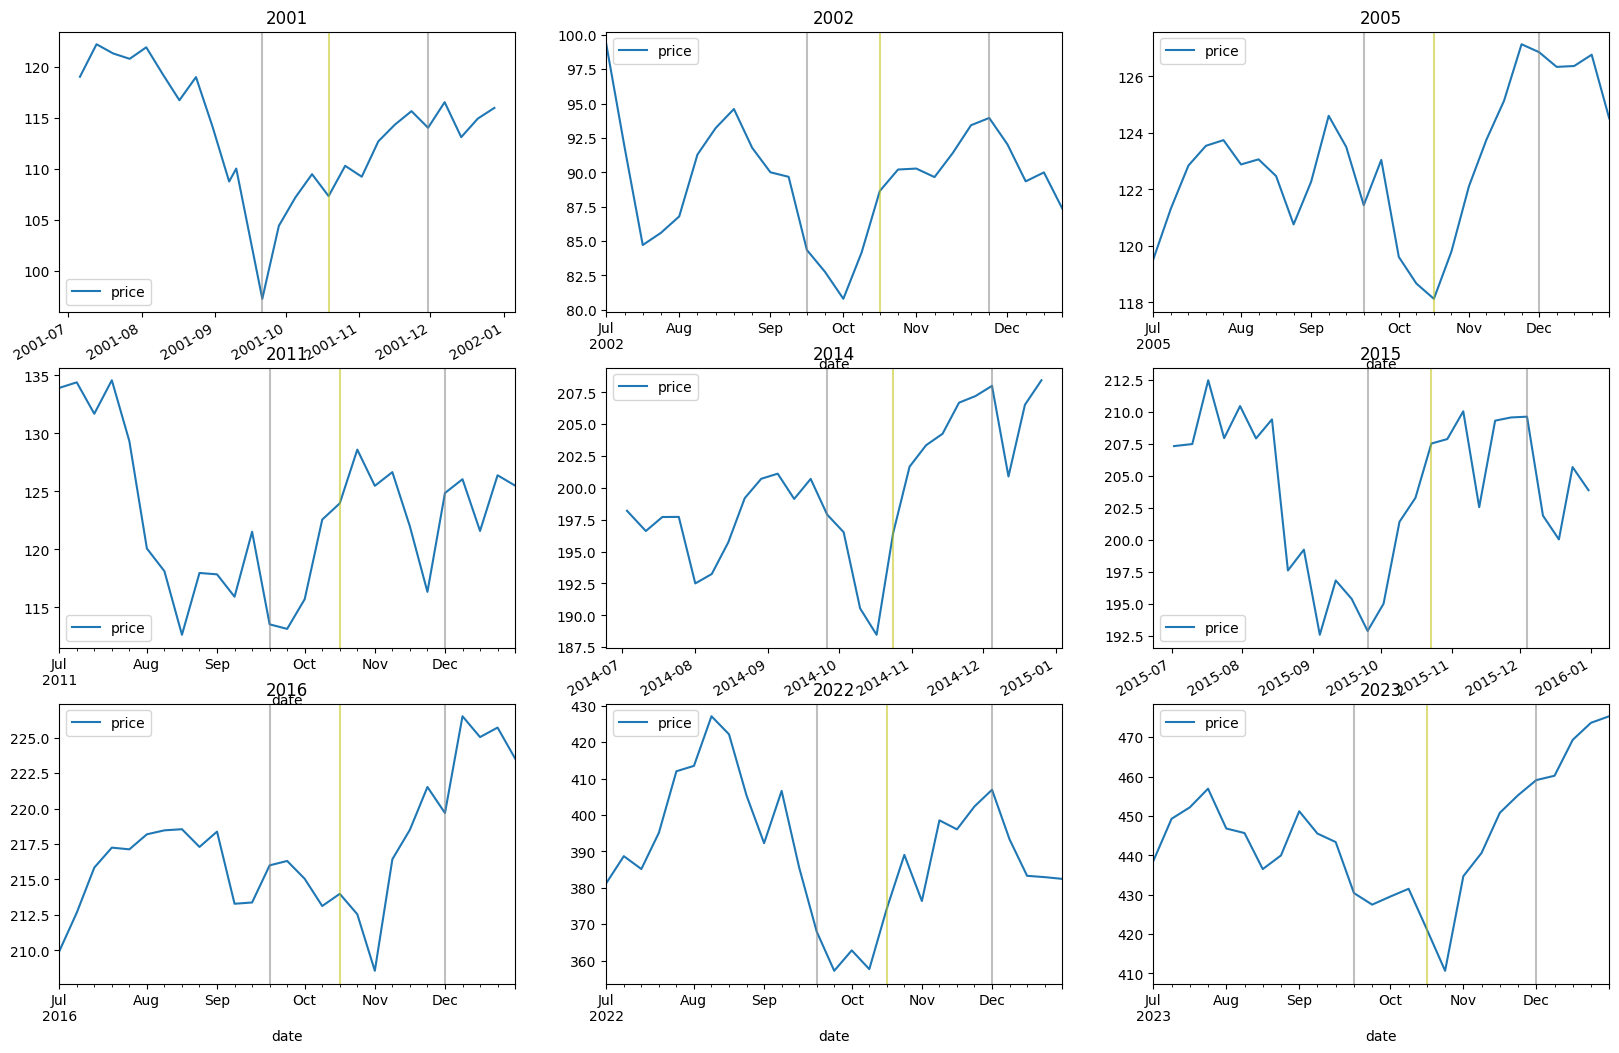

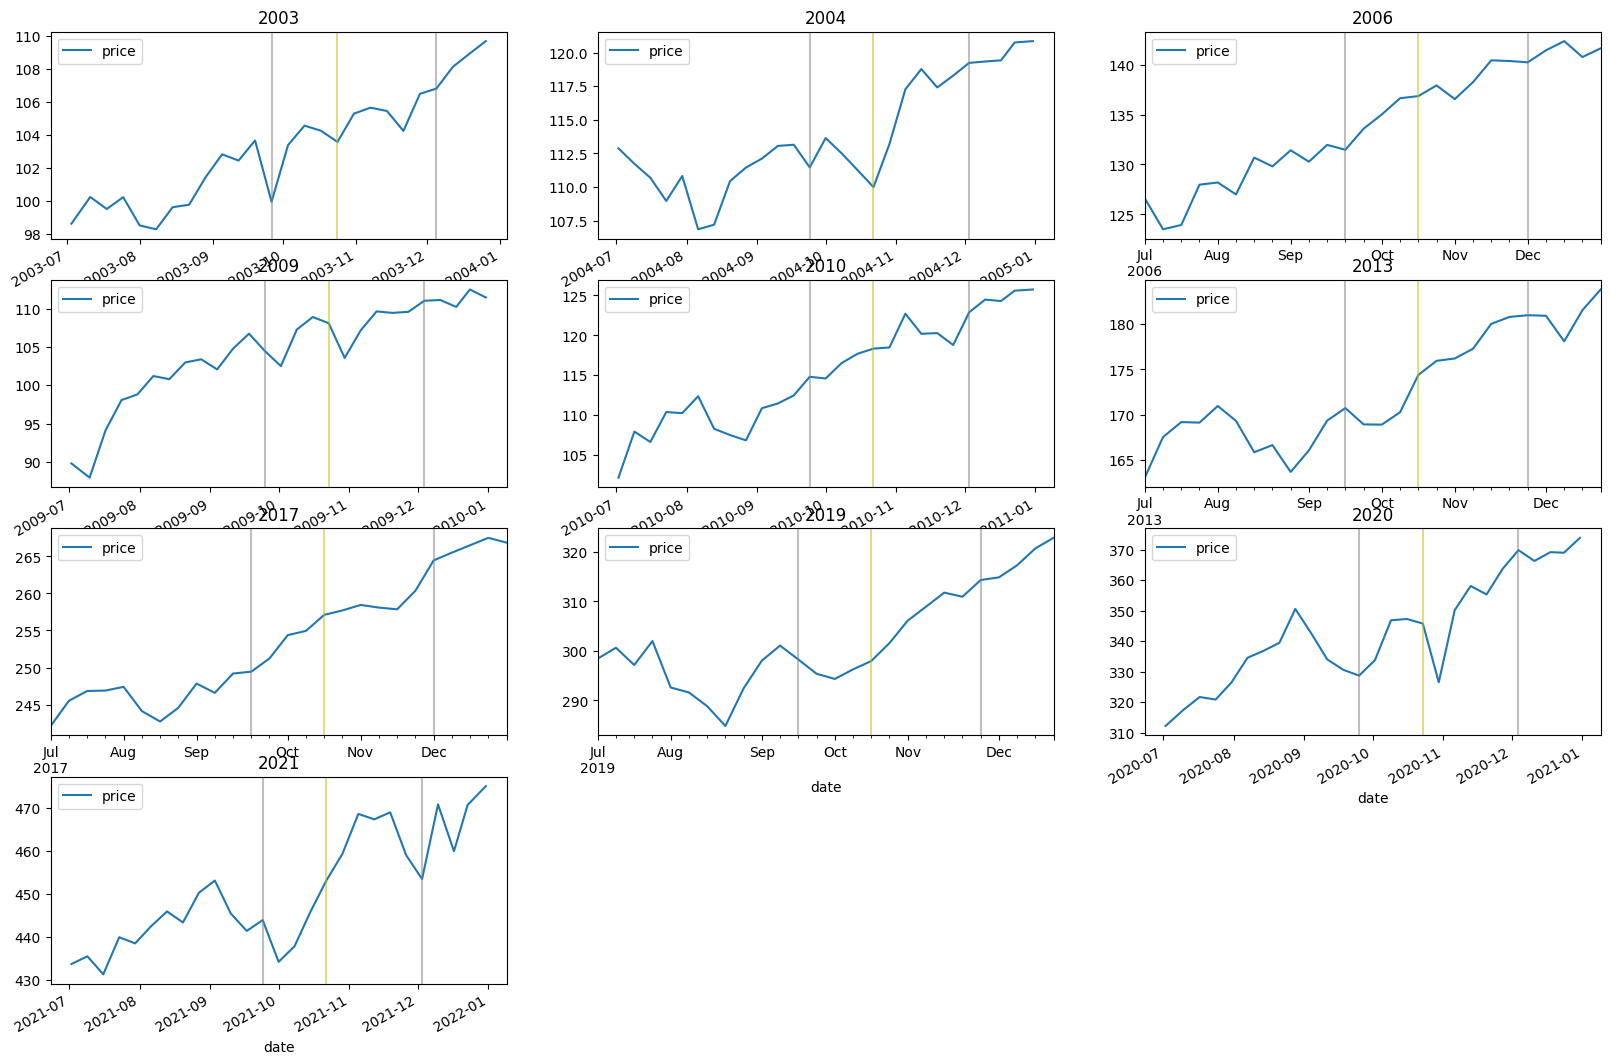

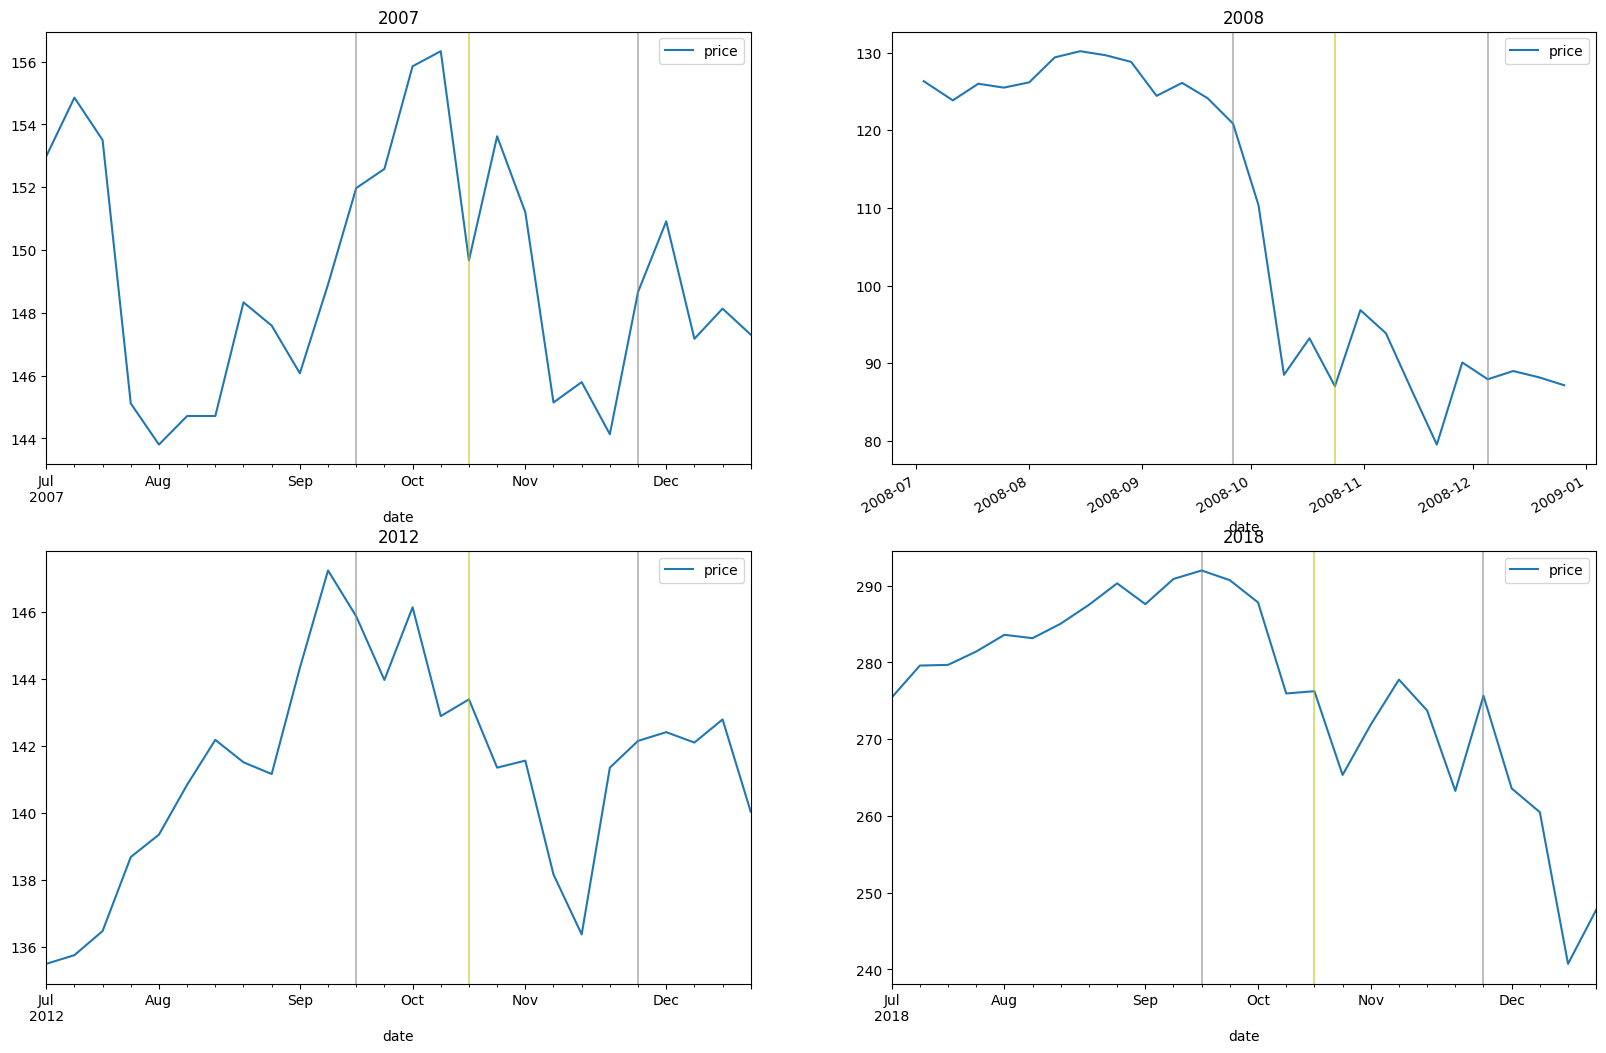

In [24]:
year_v = [2001, 2002, 2005, 2011, 2014, 2015, 2016, 2022, 2023]
year_up = [2003, 2004, 2006, 2009, 2010, 2013, 2017, 2019, 2020, 2021]
year_bad = [2007, 2008, 2012, 2018]
spy_cycle.plot_price_history(
    year_center="October", years=year_v, cols_fig=3, rows_fig=3
)
spy_cycle.plot_price_history(
    year_center="October", years=year_up, cols_fig=3, rows_fig=4
)
spy_cycle.plot_price_history(
    year_center="October", years=year_bad, cols_fig=2, rows_fig=2
)

## Case II: Starting in March
- March is another month with possible consistent gains
- One needs to skip 2020 covid for March
- The best results come from buying in on the 3rd to last Friday, and selling after 6 weeks
- 2018 is special as both Oct and Mar strategy failed, need to investigate

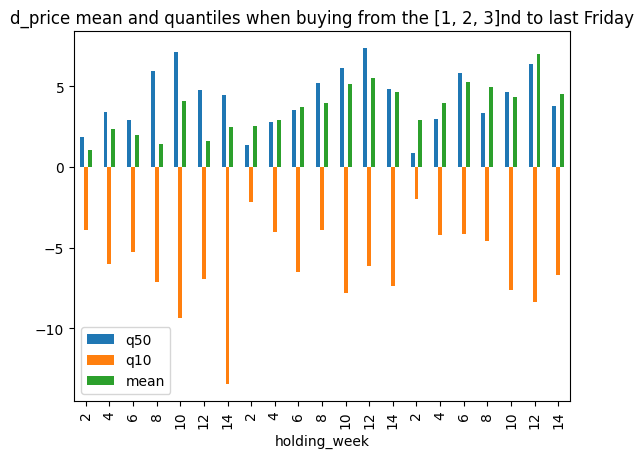

In [4]:
# Get weekly price using close price of the week
month_plot = 3
# Skip 2020 covid shutdown for March
year_skip = 2020
spy_cycle.plot_gain_by_reverse_week_holding_week(
    month_plot=month_plot, year_skip=year_skip
)

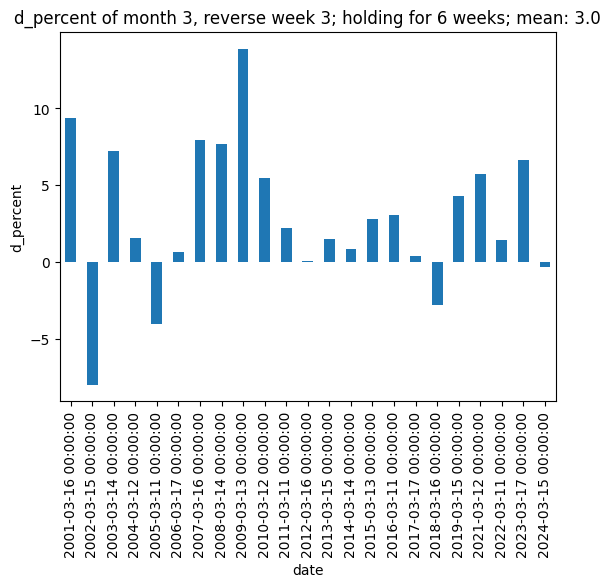

In [5]:
week_plot_reverse = 3
spy_cycle.plot_gain_by_year(
    month_plot=month_plot, week_plot_reverse=week_plot_reverse, year_skip=year_skip
)

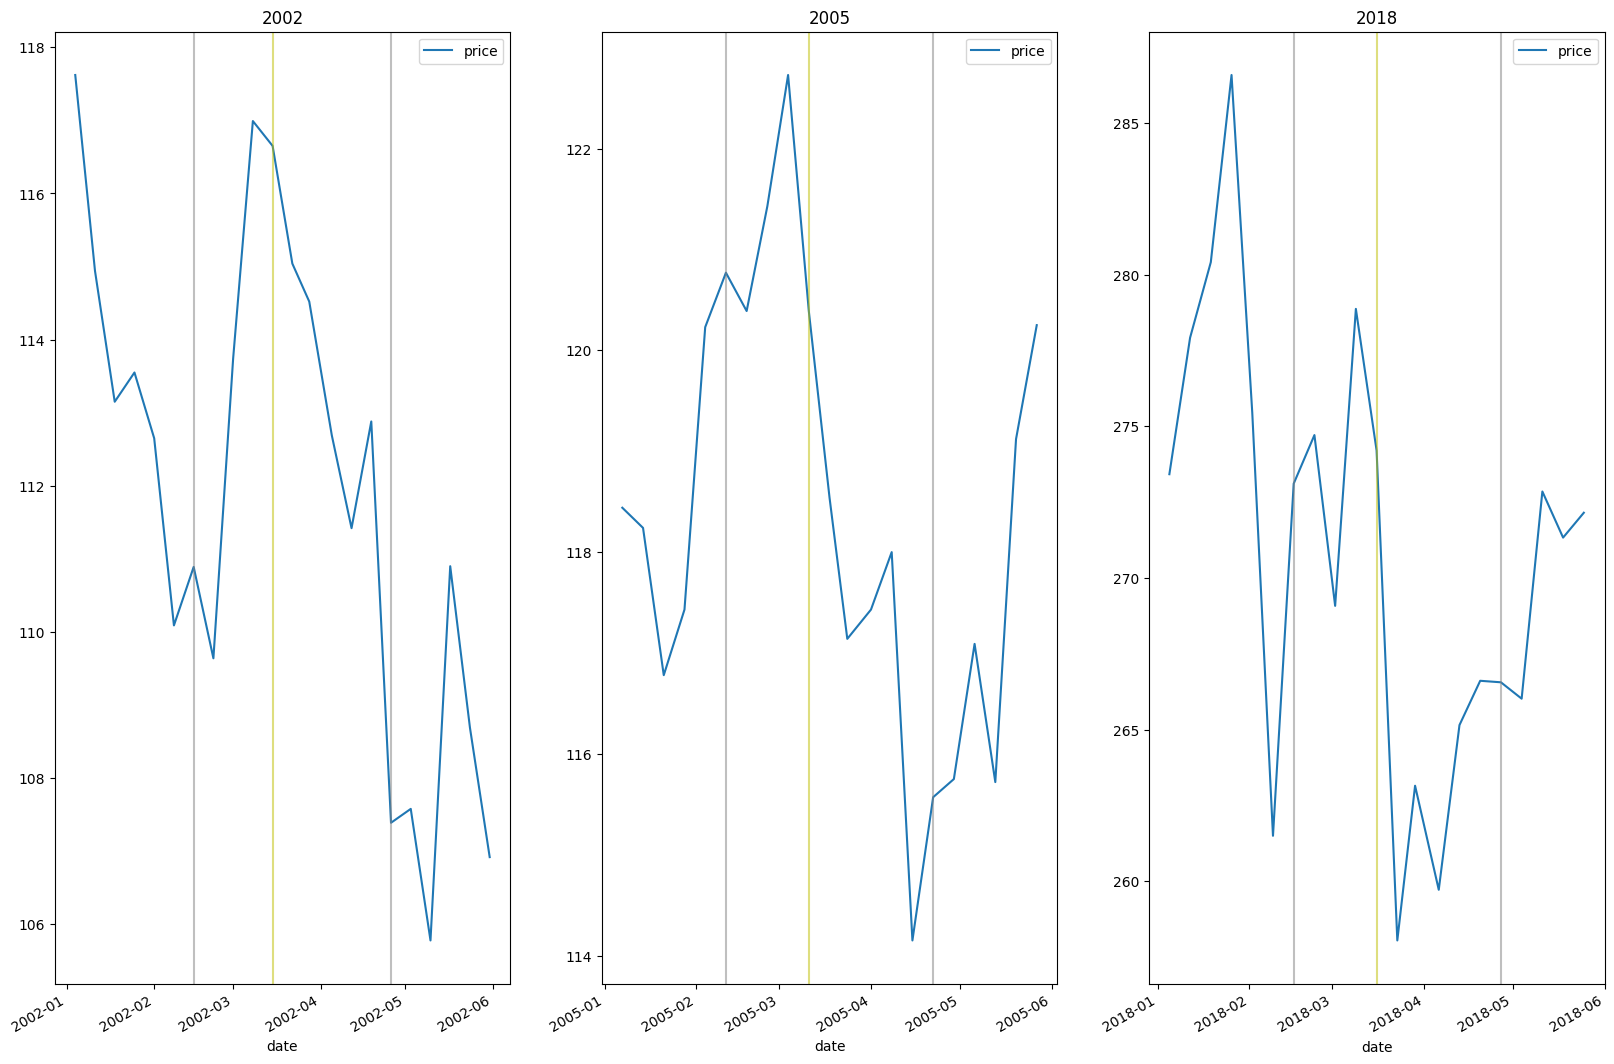

In [14]:
year_v_mar = [
    2001,
    2003,
    2004,
    2007,
    2008,
    2009,
    2011,
    2015,
    2020,
    2022,
    2023,
]
year_up_mar = [
    2006,
    2010,
    2012,
    2013,
    2014,
    2016,
    2017,
    2019,
    2021,
    2024,
]
year_v_reverse_mar = [
    2002,
    2005,
    2018,
]

spy_cycle.plot_price_history(
    year_center="March",
    years=year_v_mar,
    cols_fig=3,
    rows_fig=4,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
)
spy_cycle.plot_price_history(
    year_center="March",
    years=year_up_mar,
    cols_fig=3,
    rows_fig=4,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
)
spy_cycle.plot_price_history(
    year_center="March",
    years=year_v_reverse_mar,
    cols_fig=3,
    rows_fig=1,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
)

# Individual stocks
I noted MCD and PG also have some monthly pattern. Check them out  
I also tried key stocks in my portfolios. The only other one that has a clear and consistent cycle is KO

## MCD

In [3]:
mcd_cycle = StockCycle(symbol="MCD", n_week_shift=-6)
mcd_cycle._get_weekly()
mcd_cycle._get_weekly_gains()

In [4]:
tmp = mcd_cycle.df_weekly
tmp2 = tmp.groupby("year")["week_of_year"].count()
tmp2 = tmp2[tmp2 < 52]
print(
    f"""MCD misses the following years after 2001 {set(range(2001, 2025)) - set(tmp.year.unique())}; 
And some years have missing weeks: {tmp2} """
)

MCD misses the following years after 2001 {2005, 2006}; 
And some years have missing weeks: year
2007    42
2009    45
2024    26
Name: week_of_year, dtype: Int64 


[(-6, 1, 4.571428571428572), (-6, 2, 5.609523809523815), (-6, 3, 5.7540000000000004), (-6, 4, 6.043000000000001)]


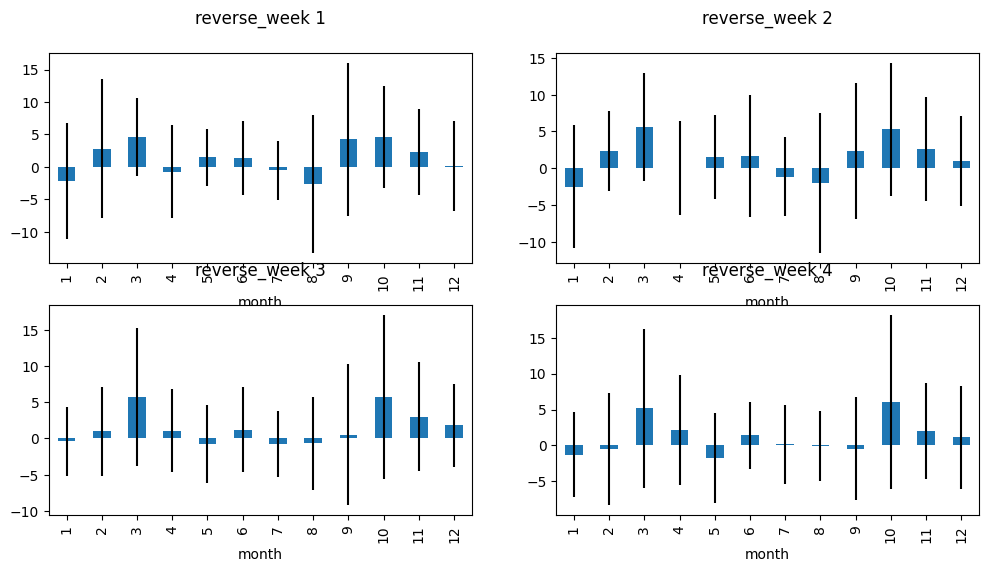

In [5]:
year_skip = 2020
mcd_cycle.plot_gains_by_reverse_week(year_skip=year_skip)

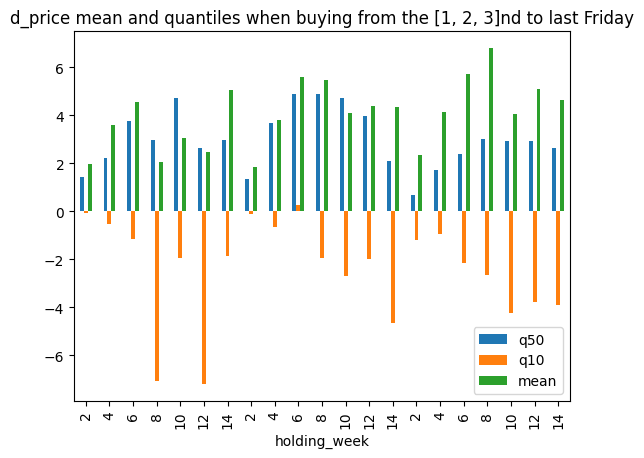

In [6]:
month_plot = 3
mcd_cycle.plot_gain_by_reverse_week_holding_week(
    month_plot=month_plot, year_skip=year_skip
)

# Best case: 2nd to last Friday, holding 6 weeks

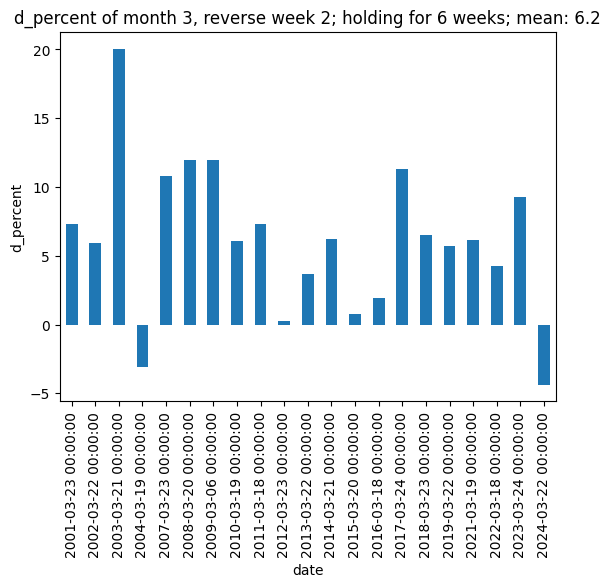

In [7]:
week_plot_reverse = 2
mcd_cycle.plot_gain_by_year(
    month_plot=month_plot,
    week_plot_reverse=week_plot_reverse,
    plot_var="d_percent",
    year_skip=year_skip,
)

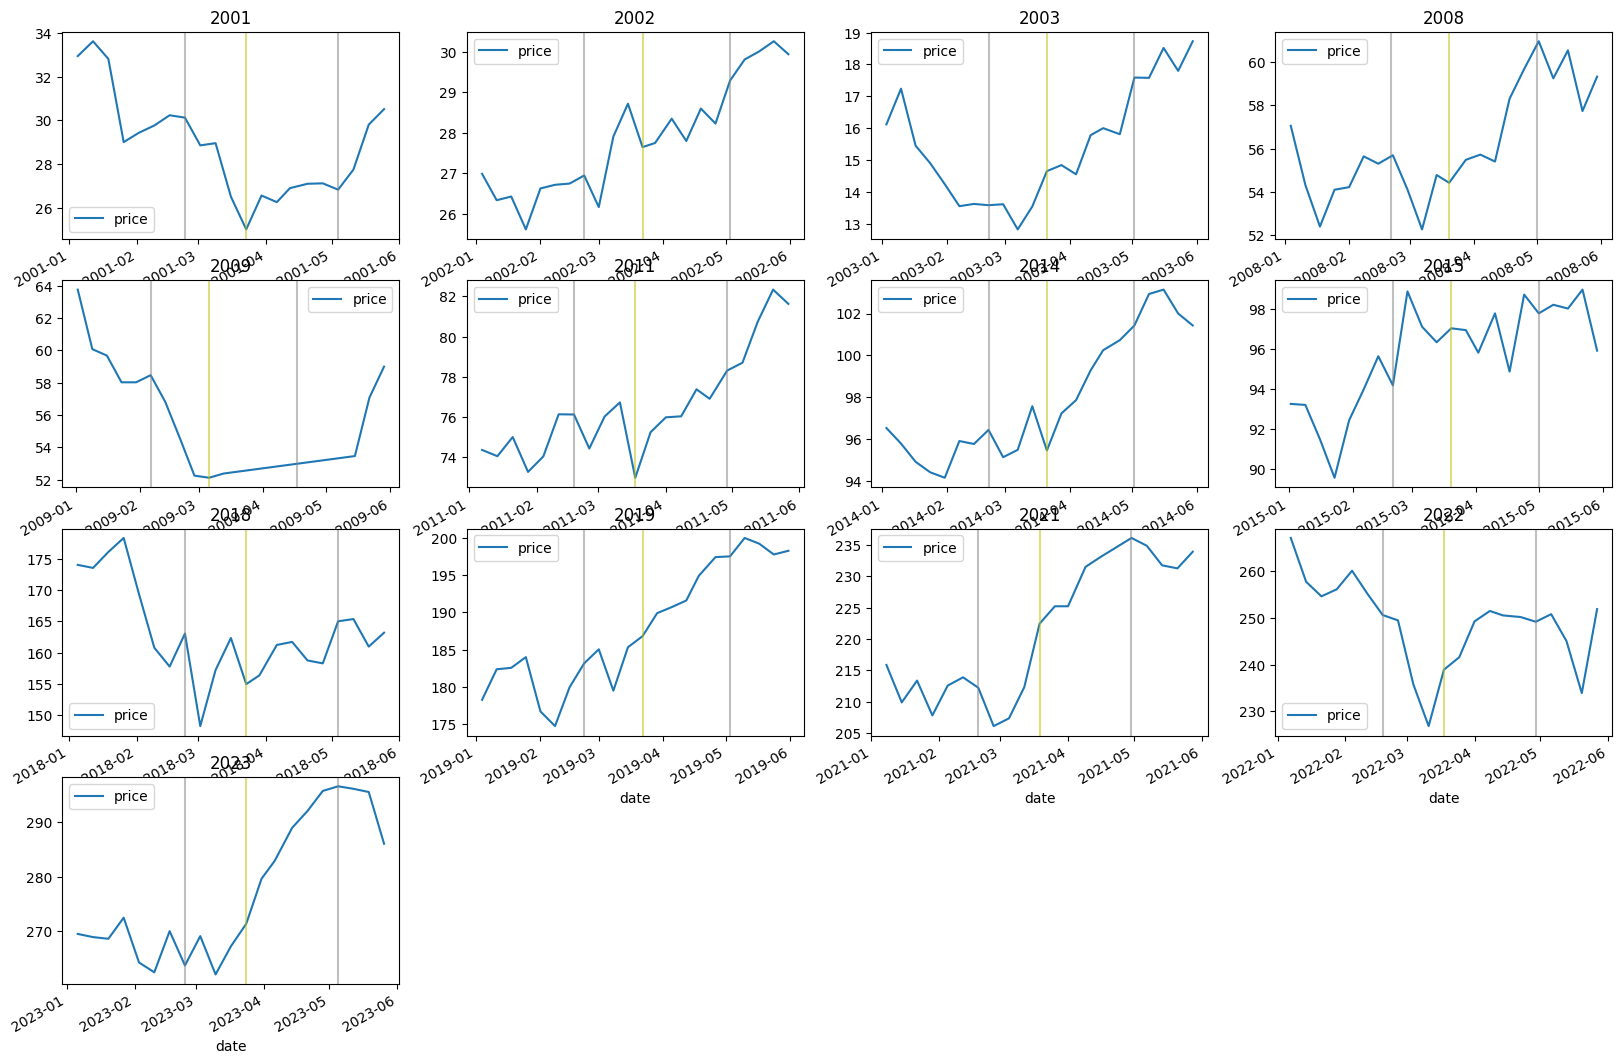

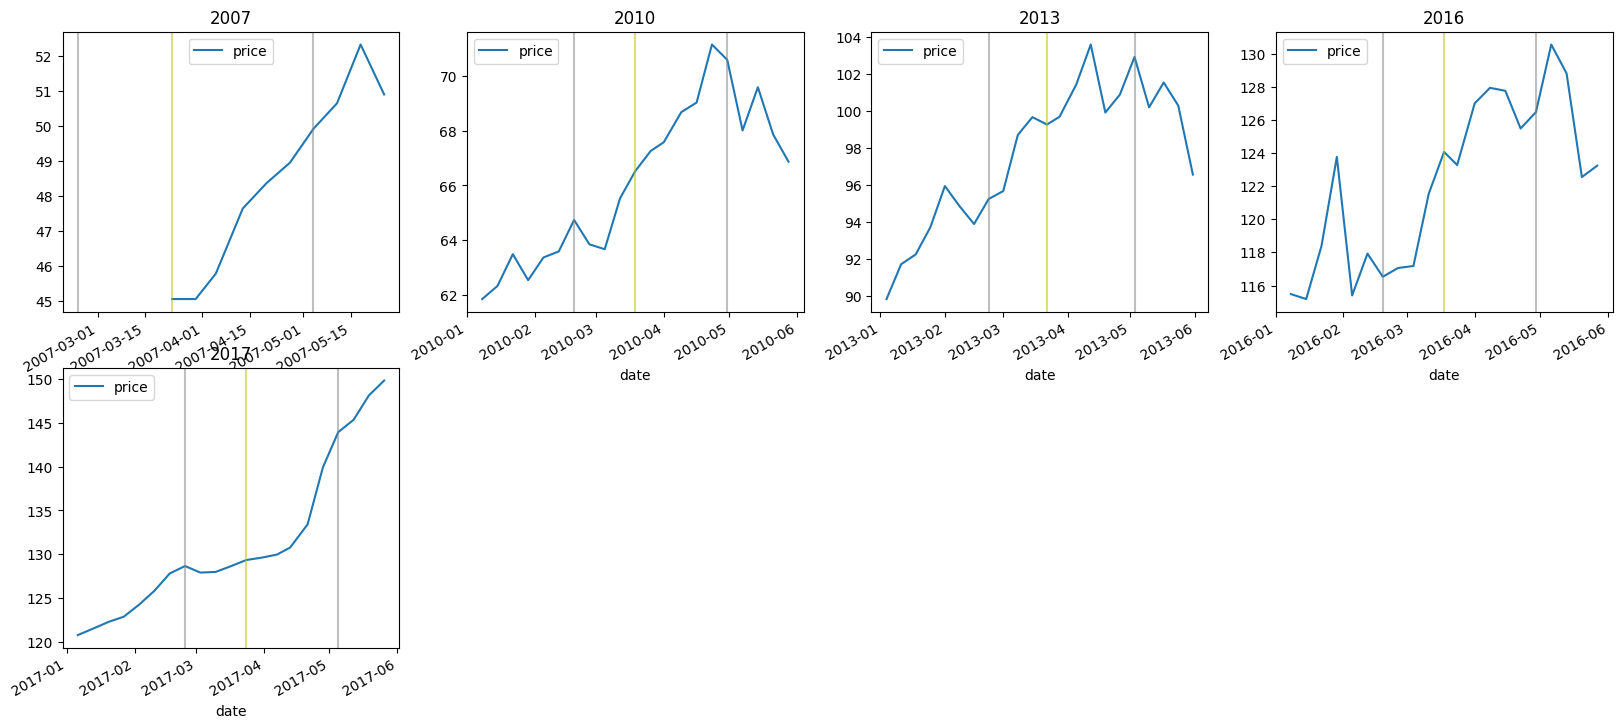

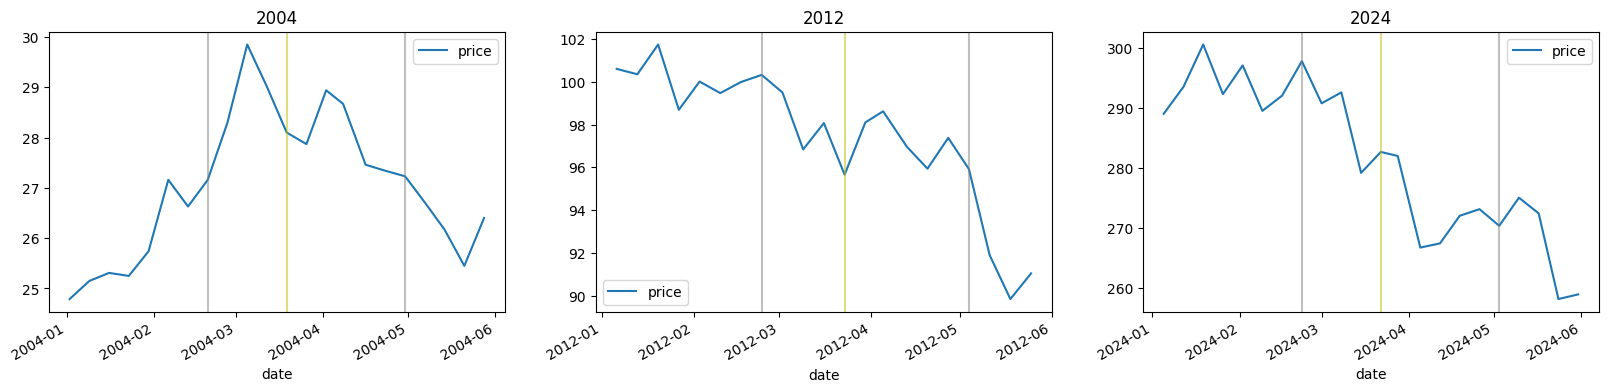

In [10]:
year_v_mcd = [
    2001,
    2002,
    2003,
    2008,
    2009,
    2011,
    2014,
    2015,
    2018,
    2019,
    2021,
    2022,
    2023,
]
year_up_mcd = [
    2007,
    2010,
    2013,
    2016,
    2017,
]
year_bad_mcd = [
    2004,
    2012,
    2024,
]
mcd_cycle.plot_price_history(
    year_center="March",
    years=year_v_mcd,
    cols_fig=4,
    rows_fig=4,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
)
mcd_cycle.plot_price_history(
    year_center="March",
    years=year_up_mcd,
    cols_fig=4,
    rows_fig=3,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
)
mcd_cycle.plot_price_history(
    year_center="March",
    years=year_bad_mcd,
    cols_fig=3,
    rows_fig=3,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
)

## PG

In [3]:
pg_cycle = StockCycle(symbol="PG", n_week_shift=-6, year_start=2001)
pg_cycle._get_weekly()
pg_cycle._get_weekly_gains()

tmp = pg_cycle.df_weekly
tmp2 = tmp.groupby("year")["week_of_year"].count()
tmp2 = tmp2[tmp2 < 52]
print(
    f"""SPY misses the following years after 2001 {set(range(2001, 2025)) - set(tmp.year.unique())}; 
And some years have missing weeks: {tmp2} """
)

SPY misses the following years after 2001 {2005, 2006}; 
And some years have missing weeks: year
2007    41
2024    26
Name: week_of_year, dtype: Int64 


[(-6, 1, 2.728000000000001), (-6, 2, 3.5234999999999994), (-6, 3, 2.7630000000000003), (-6, 4, 2.648999999999999)]


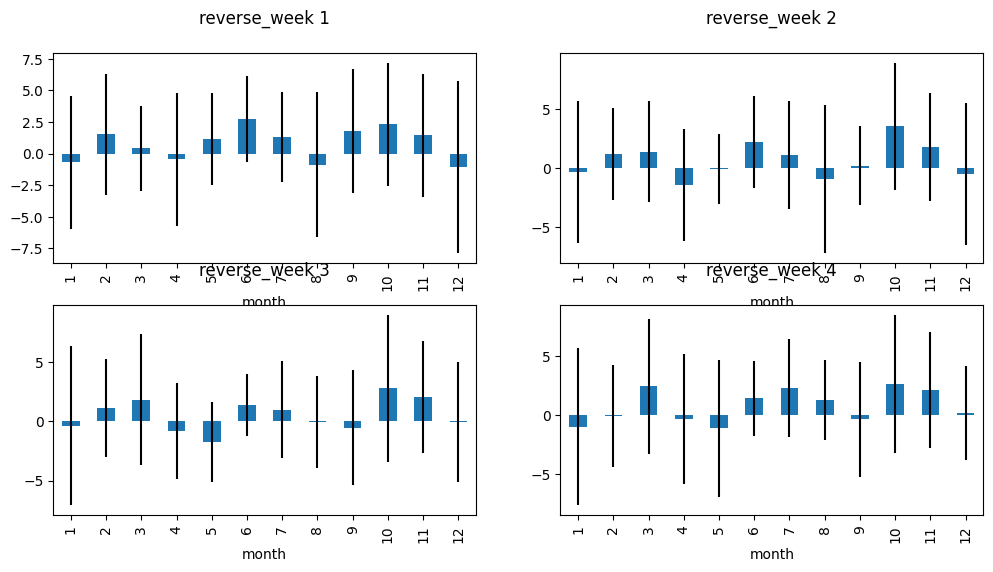

In [4]:
pg_cycle.plot_gains_by_reverse_week(year_skip=2020)
# June and Oct are two promising months; Should ge cash in Apr and Aug, as it's normally high (buying in these month yields neg gains)

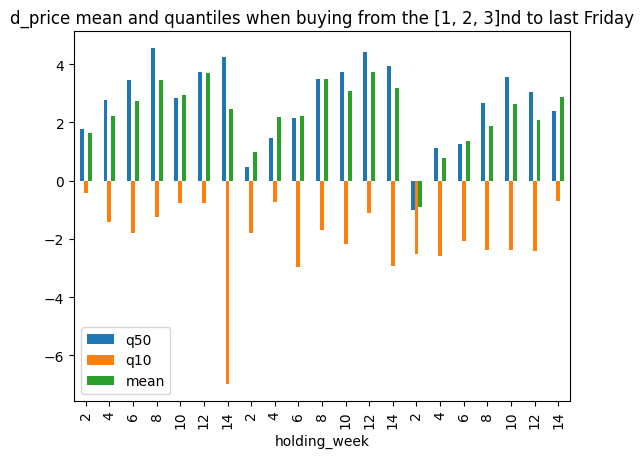

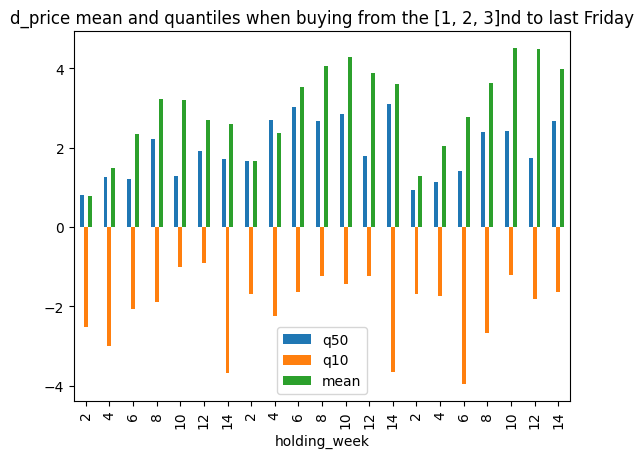

In [5]:
year_skip = 2020
pg_cycle.plot_gain_by_reverse_week_holding_week(month_plot=6, year_skip=year_skip)
pg_cycle.plot_gain_by_reverse_week_holding_week(month_plot=10, year_skip=year_skip)
# Best cases: Jun, 1, 12w; Oct, 2, 8w

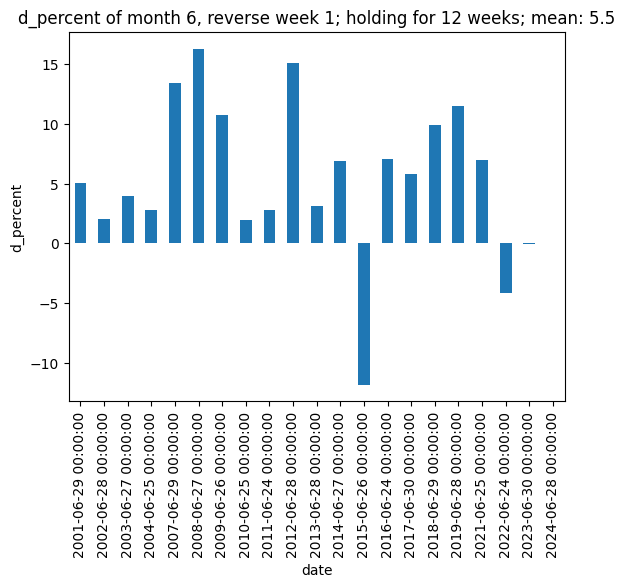

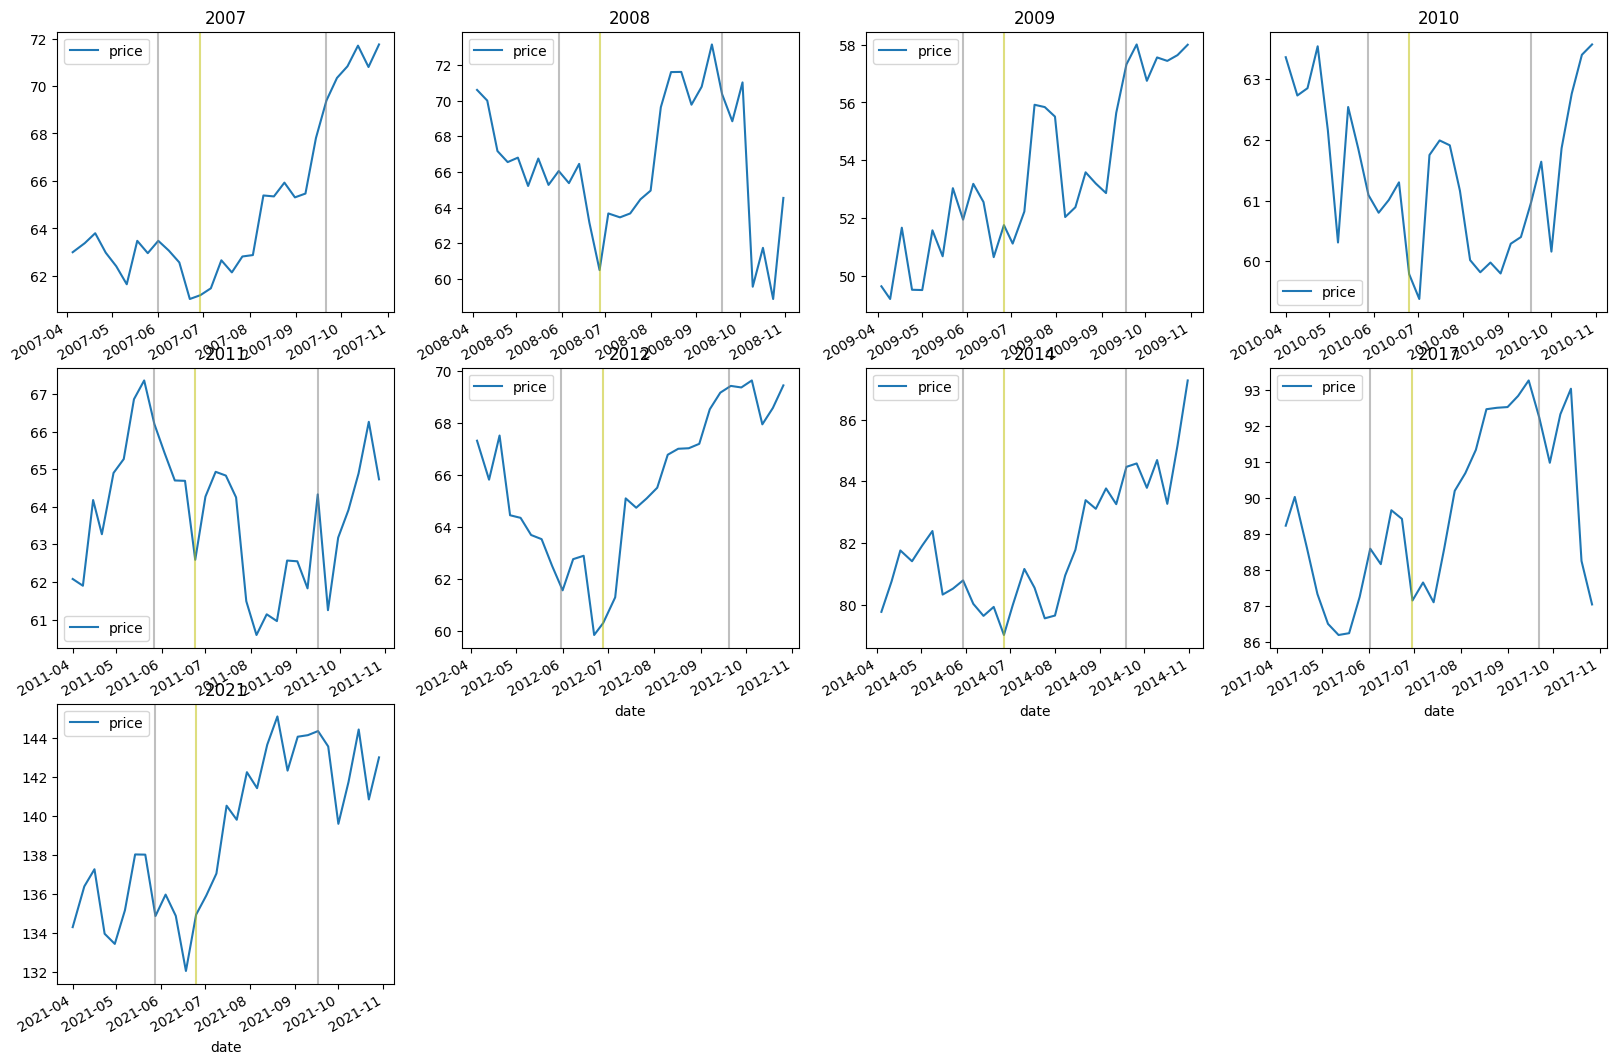

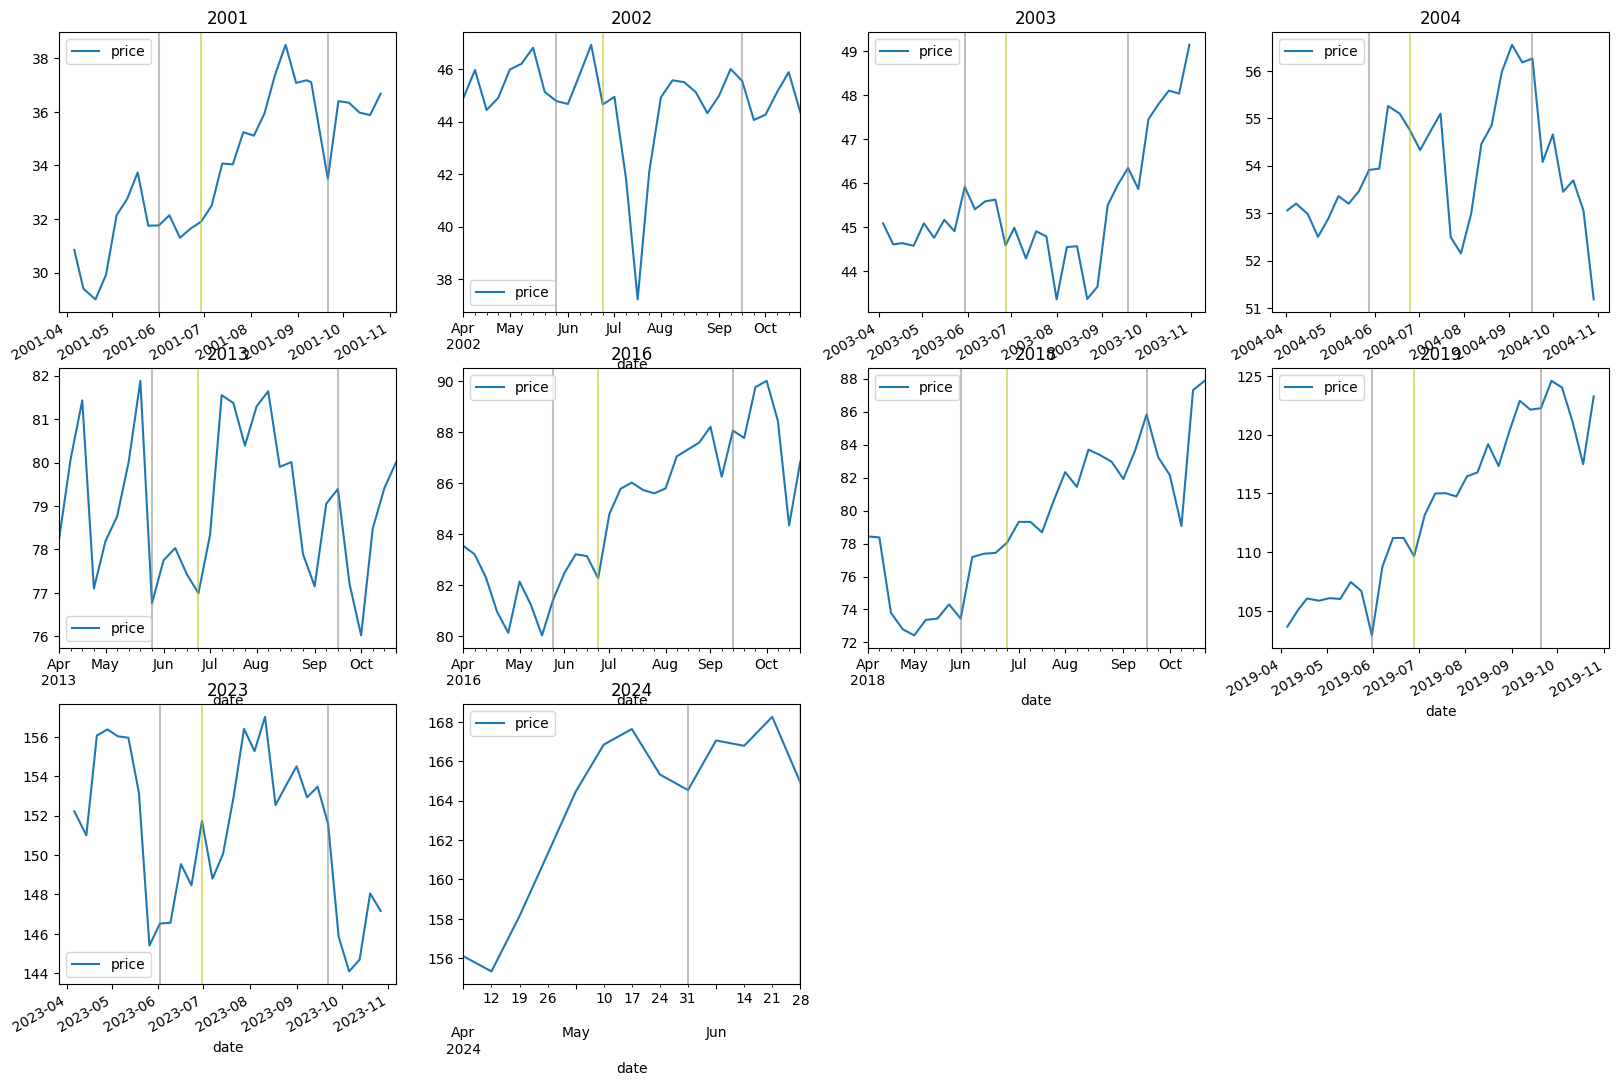

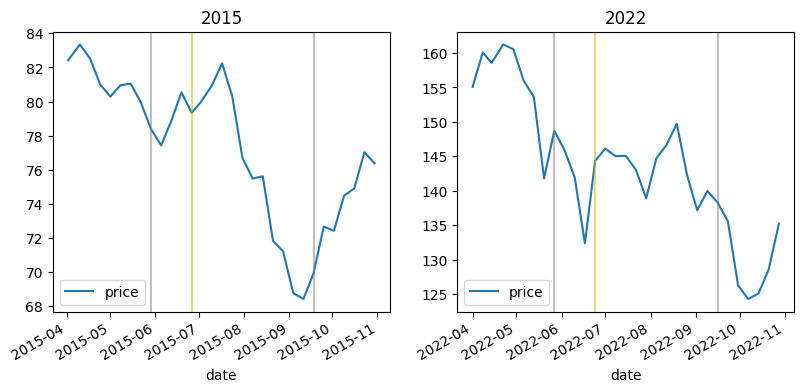

In [6]:
month_plot = 6
week_plot_reverse = 1
pg_cycle.n_week_shift = -12
pg_cycle._get_weekly_gains()
pg_cycle.plot_gain_by_year(
    month_plot=month_plot,
    week_plot_reverse=week_plot_reverse,
    plot_var="d_percent",
    year_skip=year_skip,
)

year_v_pg = [
    2007,
    2008,
    2009,
    2010,
    2011,
    2012,
    2014,
    2017,
    2021,
]
year_other_pg = [
    2001,
    2002,
    2003,
    2004,
    2013,
    2016,
    2018,
    2019,
    2023,
    2024,
]
year_bad_pg = [
    2015,
    2022,
]
pg_cycle.plot_price_history(
    year_center="June",
    years=year_v_pg,
    cols_fig=4,
    rows_fig=3,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
    vline2_week=-pg_cycle.n_week_shift,
)
pg_cycle.plot_price_history(
    year_center="June",
    years=year_other_pg,
    cols_fig=4,
    rows_fig=3,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
    vline2_week=-pg_cycle.n_week_shift,
)
pg_cycle.plot_price_history(
    year_center="June",
    years=year_bad_pg,
    cols_fig=4,
    rows_fig=3,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
    vline2_week=-pg_cycle.n_week_shift,
)

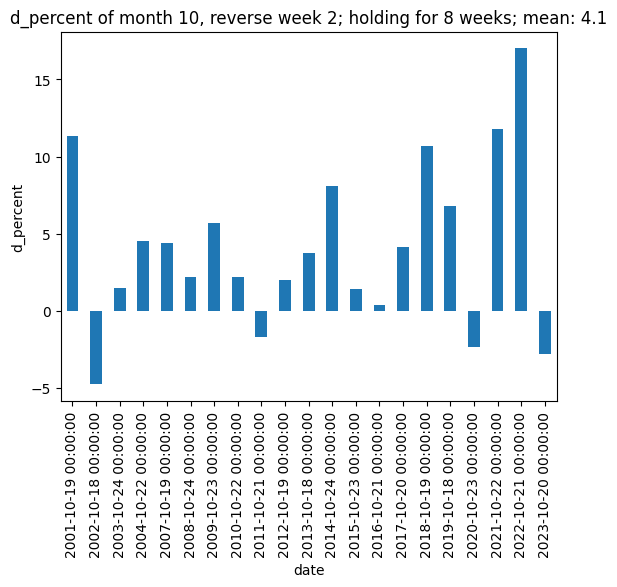

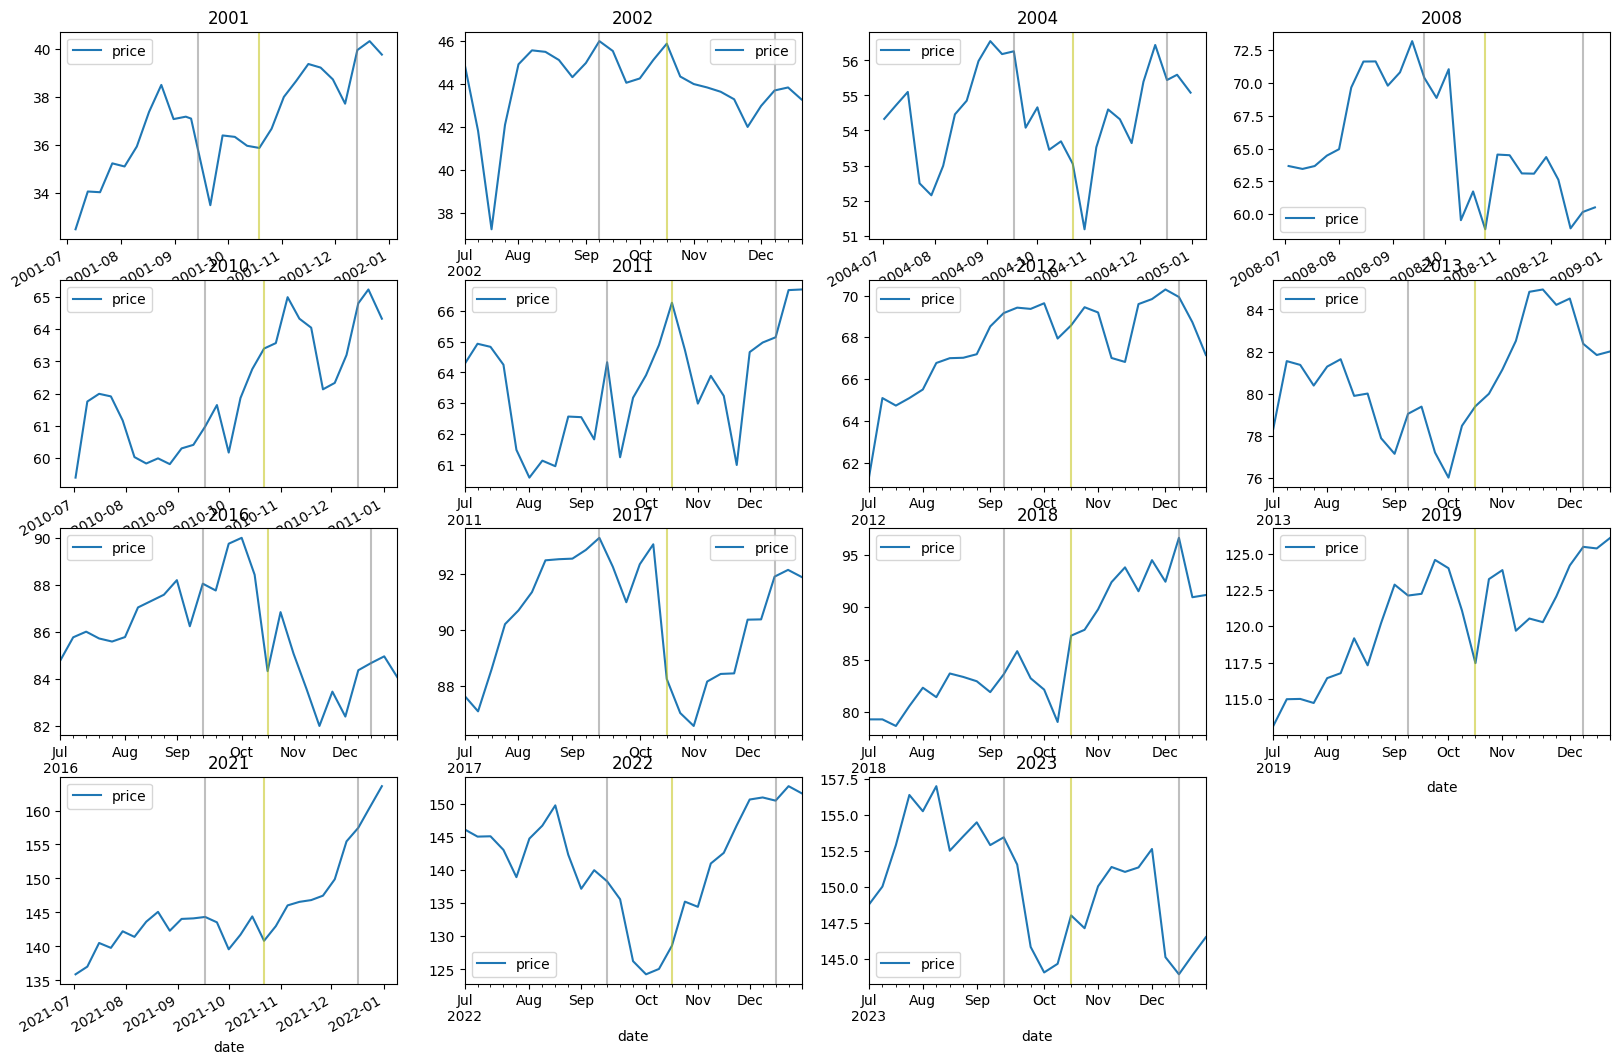

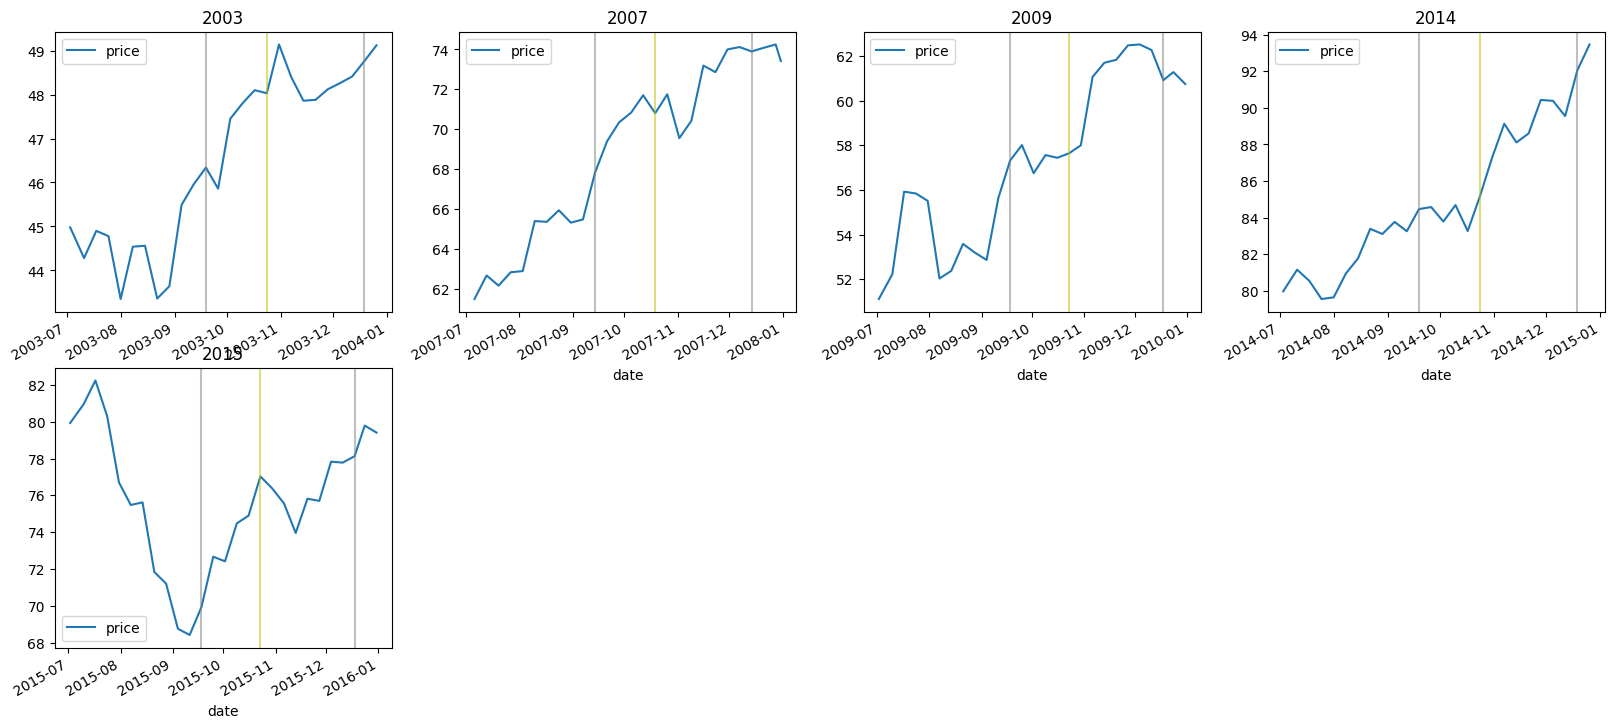

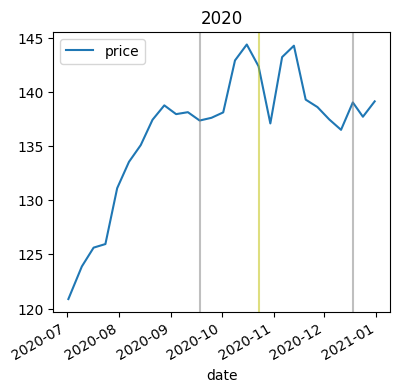

In [28]:
month_plot = 10
week_plot_reverse = 2
pg_cycle.n_week_shift = -8
vline1_week = 5  # when to start to buying window

pg_cycle._get_weekly_gains()
pg_cycle.plot_gain_by_year(
    month_plot=month_plot,
    week_plot_reverse=week_plot_reverse,
    plot_var="d_percent",
    # year_skip=year_skip,
)

year_v_pg = [
    2001,
    2002,
    2004,
    2008,
    2010,
    2011,
    2012,
    2013,
    2016,
    2017,
    2018,
    2019,
    2021,
    2022,
    2023,
]
year_up_pg = [
    2003,
    2007,
    2009,
    2014,
    2015,
]
year_bad_pg = [
    2020,
]

pg_cycle.plot_price_history(
    year_center="October",
    years=year_v_pg,
    cols_fig=4,
    rows_fig=4,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
    vline1_week=vline1_week,
    vline2_week=-pg_cycle.n_week_shift,
)

pg_cycle.plot_price_history(
    year_center="October",
    years=year_up_pg,
    cols_fig=4,
    rows_fig=3,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
    vline1_week=vline1_week,
    vline2_week=-pg_cycle.n_week_shift,
)

pg_cycle.plot_price_history(
    year_center="October",
    years=year_bad_pg,
    cols_fig=4,
    rows_fig=3,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
    vline1_week=vline1_week,
    vline2_week=-pg_cycle.n_week_shift,
)

## KO

Stock misses the following years after 2001 {2005, 2006}; 
And some years have missing weeks: year
2007    42
2024     6
Name: week_of_year, dtype: Int64 
[(-6, 1, 1.5268421052631573), (-6, 2, 1.9309999999999998), (-6, 3, 2.408947368421052), (-6, 4, 2.150526315789472)]


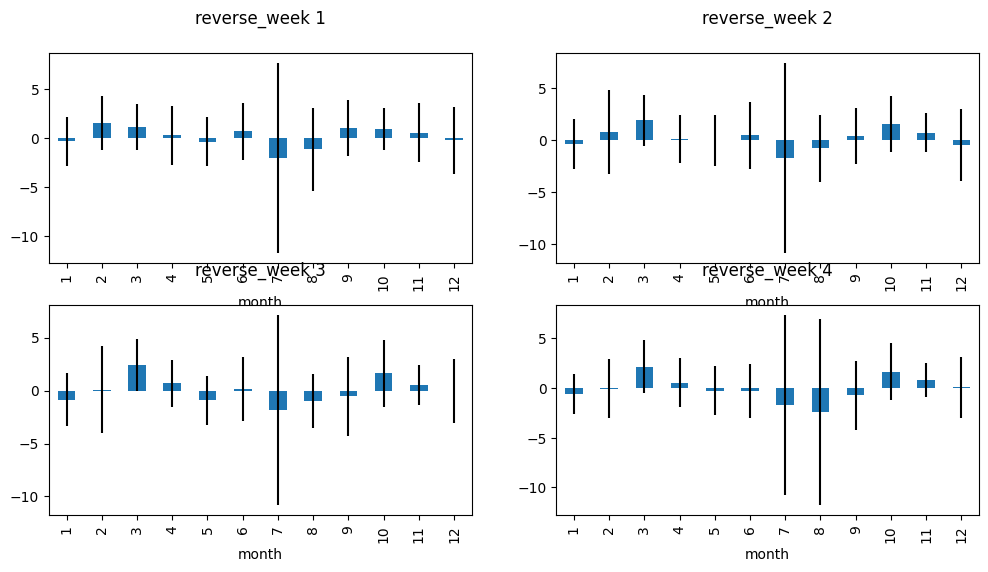

In [14]:
ko_cycle = StockCycle(symbol="KO", n_week_shift=-6, year_start=2001)
ko_cycle._get_weekly()
ko_cycle._get_weekly_gains()

tmp = ko_cycle.df_weekly
tmp2 = tmp.groupby("year")["week_of_year"].count()
tmp2 = tmp2[tmp2 < 52]
print(
    f"""Stock misses the following years after 2001 {set(range(2001, 2025)) - set(tmp.year.unique())}; 
And some years have missing weeks: {tmp2} """
)
ko_cycle.plot_gains_by_reverse_week(year_skip=2020)
# March is good month. Should get cash in Jan, as it's normally high (buying in these month yields neg gains)

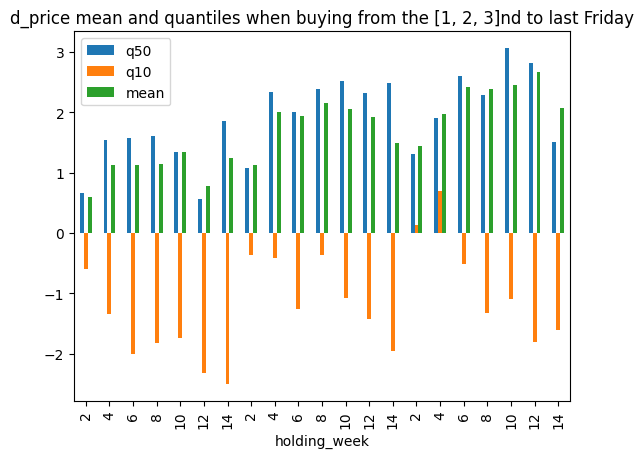

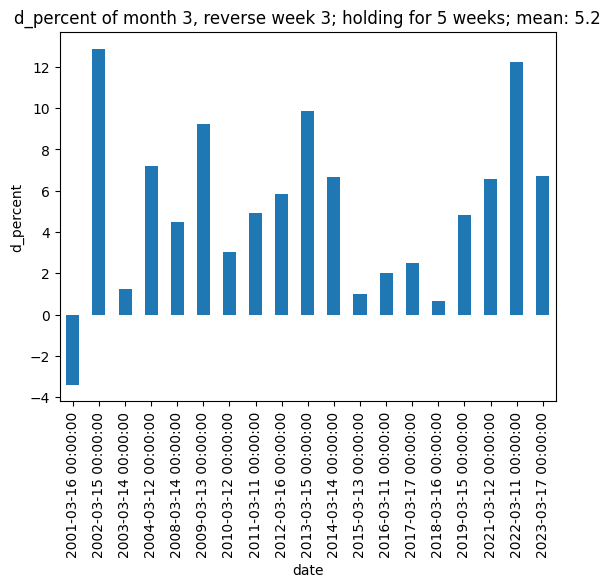

In [15]:
month_plot = 3
year_skip = 2020

# Best case: 3rd to last Friday, holding ~4 weeks
ko_cycle.plot_gain_by_reverse_week_holding_week(
    month_plot=month_plot, year_skip=year_skip
)

# Tried different holding weeks. 5 weeks is the best
week_plot_reverse = 3
ko_cycle.n_week_shift = -5
ko_cycle._get_weekly_gains()
ko_cycle.plot_gain_by_year(
    month_plot=month_plot,
    week_plot_reverse=week_plot_reverse,
    plot_var="d_percent",
    year_skip=year_skip,
)

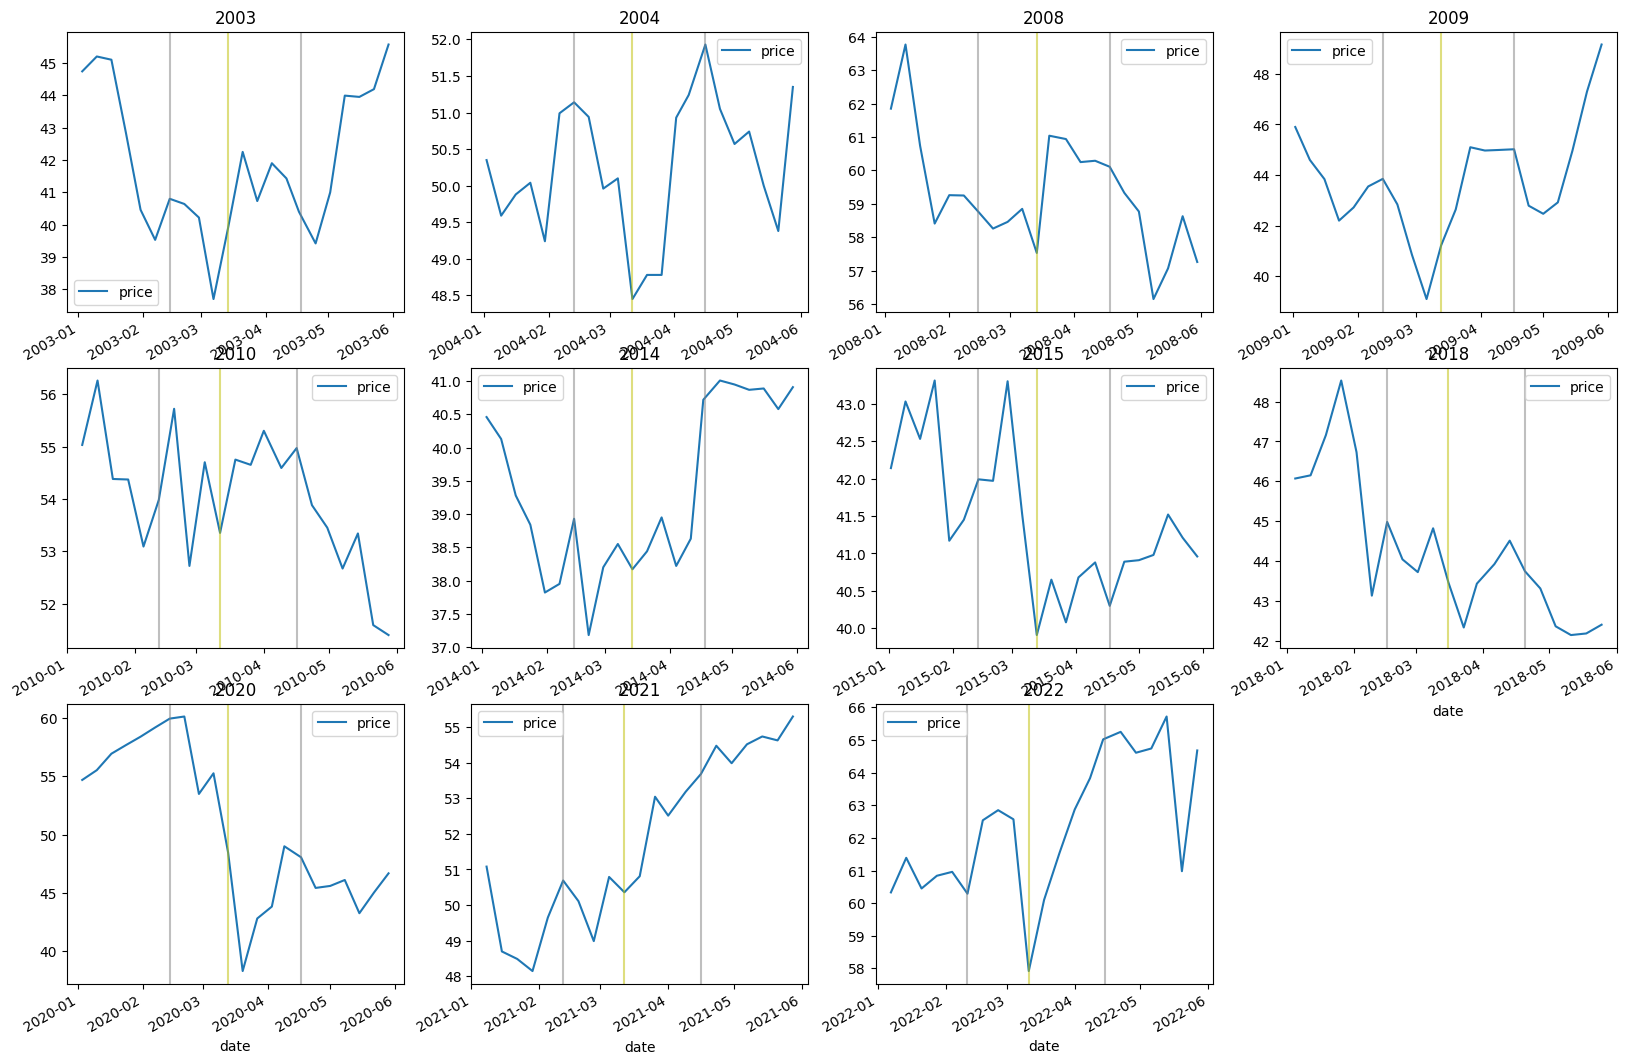

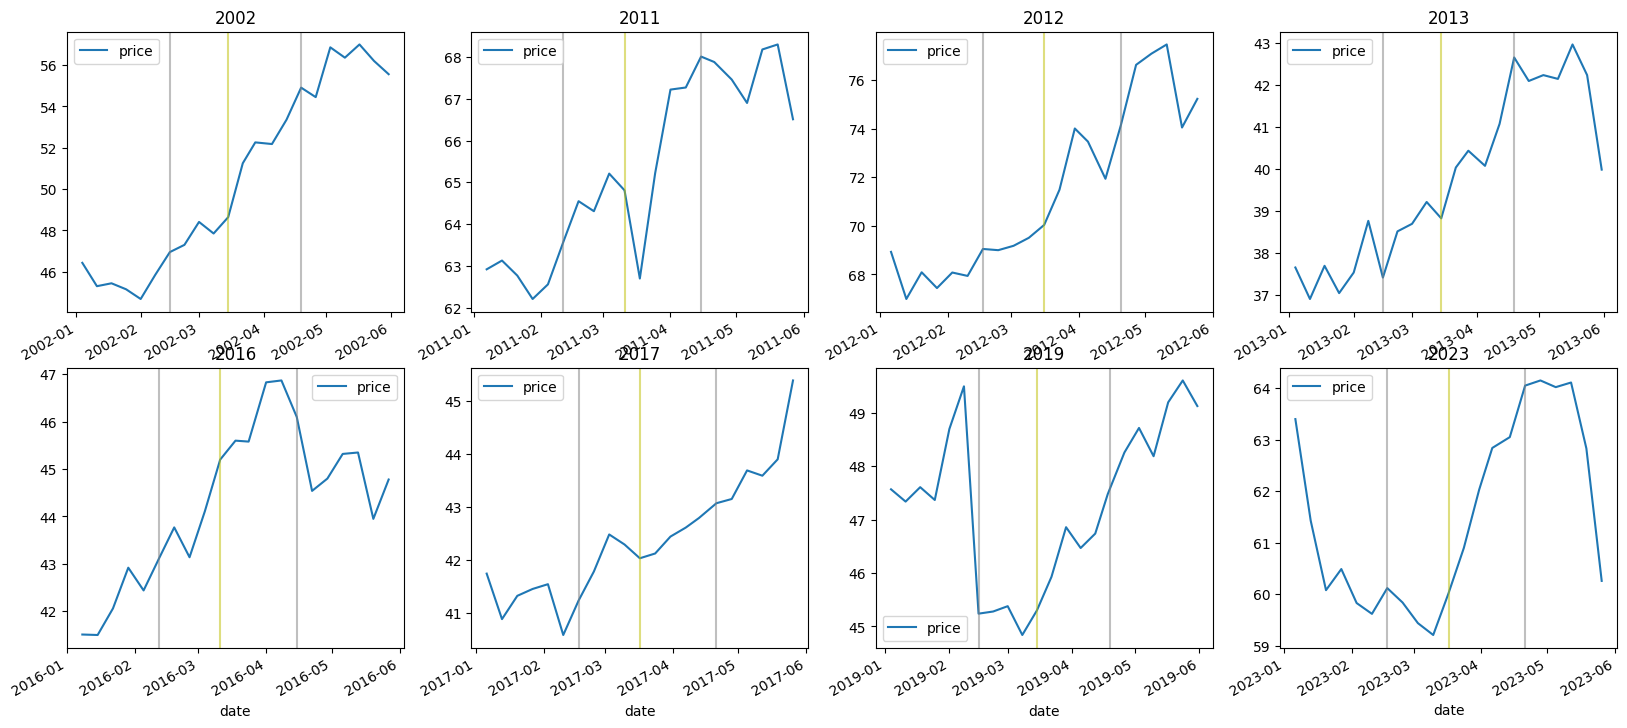

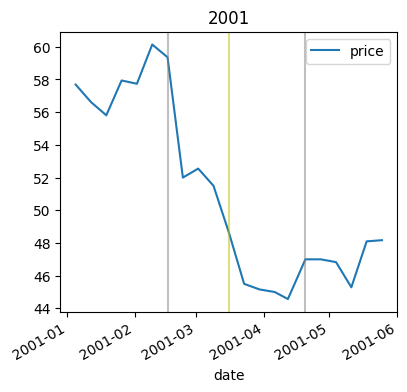

In [27]:
year_v_ko = [2003, 2004, 2008, 2009, 2010, 2014, 2015, 2018, 2020, 2021, 2022,]
year_up_ko = [
    2002, 2011, 2012, 2013, 2016, 2017, 2019, 2023,
]
year_bad_ko = [2001,]
ko_cycle.plot_price_history(
    year_center="March",
    years=year_v_ko,
    cols_fig=4,
    rows_fig=3,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
    vline2_week=-ko_cycle.n_week_shift,
)
ko_cycle.plot_price_history(
    year_center="March",
    years=year_up_ko,
    cols_fig=4,
    rows_fig=3,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
    vline2_week=-ko_cycle.n_week_shift,
)
ko_cycle.plot_price_history(
    year_center="March",
    years=year_bad_ko,
    cols_fig=4,
    rows_fig=3,
    month=month_plot,
    week_of_month_reverse=week_plot_reverse,
    vline2_week=-ko_cycle.n_week_shift,
)

# End